# Rally Stage Report for Dakar Rally

Generate a rally report for a single stage on the Dakar Rally, showing progression across splits.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Dakar_Rally_2020 as dr

In [686]:
from Dakar_Rally_2020 import get_timing_data_long_timeInSplit, \
                                get_long_annotated_timing_data, TIME, RANK, \
                                rebaseWaypointTimes, pivotRebasedSplits, \
                                get_driver_data, cleanDriverSplitReportBaseDataframe, \
                                get_timing_data, insertColumn, moveColumn, \
                                get_ranking_data, getCurrPrevOverallRank

from dakar_utils import moreStyleDriverSplitReportBaseDataframe, \
                        sparkline2, sparklineStep, getTablePNG
                                
import sqlite3
from sqlite_utils import Database
import pandas as pd

In [687]:
dbname = 'dakar_2020.db'

conn = sqlite3.connect(dbname)
db = Database(conn)

In [688]:
q="SELECT name FROM sqlite_master WHERE type = 'table';"
pd.read_sql(q, conn)

,name
0,teams
1,crew
2,vehicles
3,stagestats
4,ranking
5,waypoints


In [689]:
STAGE = 1
VTYPE = 'car'


In [690]:
REBASER = 305 #Alonso - 310, Sainz 305
CHART_POSITIONS = 15 #None for all


MAXMISSING = 10

In [691]:
timing_data_long = get_long_annotated_timing_data(STAGE, VTYPE)[TIME]
timing_data_long_insplit = get_timing_data_long_timeInSplit(STAGE, VTYPE)
timing_data_long_min = rebaseWaypointTimes( timing_data_long , REBASER, 'TimeInS')
timing_data_long_min.head(3)

,Pos,Bib,Road Position,Refuel,Crew,Brand,Waypoint,Time,TimeInS,rebased
83,1.0,319,19.0,False,V. ZALA S. JURGELENAS AGRORODEO,MINI,01_km47,00:36:18,2178.0,95.0
84,2.0,302,3.0,False,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,01_km47,00:35:30,2130.0,47.0
85,3.0,305,6.0,False,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,01_km47,00:34:43,2083.0,0.0


In [692]:
rb2c = pivotRebasedSplits(rebaseWaypointTimes(timing_data_long_insplit,REBASER))
rb2c = cleanDriverSplitReportBaseDataframe(rb2c, STAGE)
top10 = get_driver_data(STAGE, CHART_POSITIONS)

#rb2cTop10 = rb2c[rb2c.index.isin(top10['Bib'])]
rb2cTop10 = pd.merge(top10, rb2c, how='left', left_index=True, right_index=True)
rb2cTop10.head(2)

,Pos,Road Position,Crew,Brand,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass
Bib,,,,,,,,,,,
319,1.0,19.0,V. ZALA S. JURGELENAS AGRORODEO,MINI,-95.0,-74.0,607.0,-120.0,-50.0,-47.0,-51.0
302,2.0,3.0,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,-47.0,6.0,627.0,-361.0,-39.0,-89.0,-61.0


In [693]:
#Need processing on the below - also change column order
newColOrder = rb2cTop10.columns[1:].tolist()+[rb2cTop10.columns[0]]
rb2cTop10=rb2cTop10[newColOrder]
rb2cTop10 = pd.merge(rb2cTop10, -timing_data_long_min.reset_index().pivot('Bib','Waypoint','rebased'),
                     how='left', left_index=True,right_index=True)


#Cast s to timedelta

#for c in [c for c in rb2cTop10.columns if c.startswith('0')]:
#    rb2cTop10[c]=rb2cTop10[c].apply(lambda x: pd.to_timedelta('{}00:00:{}'.format('-' if x<0 else '', '0' if pd.isnull(x) else abs(x))))

#Rename last column
rb2cTop10.rename(columns={rb2cTop10.columns[-1]:'Stage Overall'}, inplace=True)

rb2cTop10.dropna(how='all',axis=1,inplace=True)

#Drop very gappy waypoint cols
rb2cTop10.dropna(thresh=MAXMISSING,axis=1,inplace=True)

rb2cTop10.head(3)

,Road Position,Crew,Brand,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass,Pos,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,
319,19.0,V. ZALA S. JURGELENAS AGRORODEO,MINI,-95.0,-74.0,607.0,-120.0,-50.0,-47.0,-51.0,1.0,-95.0,-169.0,438.0,318.0,268.0,221.0,170.0
302,3.0,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,-47.0,6.0,627.0,-361.0,-39.0,-89.0,-61.0,2.0,-47.0,-41.0,586.0,225.0,186.0,97.0,36.0
305,6.0,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [694]:
from IPython.display import HTML

In [695]:
s2 = moreStyleDriverSplitReportBaseDataframe(rb2cTop10, STAGE)
display(HTML(s2))

,Road Position,Crew,Brand,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass,Pos,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,
319,19,V. ZALA S. JURGELENAS AGRORODEO,MINI,-95,-74,607,-120,-50,-47,-51,1,-95,-169,438,318,268,221,170
302,3,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,-47,6,627,-361,-39,-89,-61,2,-47,-41,586,225,186,97,36
305,6,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,0,0,0,0,0,0,0,3,-0,-0,-0,-0,-0,-0,-0
300,1,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING,TOYOTA,43,29,584,-55,-428,-256,-80,4,43,72,656,601,173,-83,-163
307,8,B. TEN BRINKE T. COLSOUL TOYOTA GAZOO RACING,TOYOTA,-78,-77,488,-118,-253,-119,-63,5,-78,-155,333,215,-38,-157,-220
311,12,O. TERRANOVA B. GRAUE X-RAID MINI JCW TEAM,MINI,3,-109,566,-477,23,-79,-192,6,3,-106,460,-17,6,-73,-265
315,15,M. SERRADORI F. LURQUIN SRT RACING,CENTURY,-12,-16,378,-258,-105,-157,-195,7,-12,-28,350,92,-13,-170,-365
317,17,V. VASILYEV V. YEVTYEKHOV X-RAID G-ENERGY,MINI,-220,-196,490,-63,-75,-414,-157,8,-220,-416,74,11,-64,-478,-635
309,10,Y. AL RAJHI K. ZHILTSOV OVERDRIVE TOYOTA,TOYOTA,-604,24,655,-290,-22,-289,-130,9,-604,-580,75,-215,-237,-526,-656


In [696]:
rb2cTop10['test']= rb2cTop10[[c for c in rb2cTop10.columns if c.startswith(('0','1','Stage Overall'))]].values.tolist()
#Swap the sign of the values
rb2cTop10['test'] = rb2cTop10['test'].apply(lambda x: [-y for y in x])
rb2cTop10.head()

,Road Position,Crew,Brand,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass,Pos,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall,test
Bib,,,,,,,,,,,,,,,,,,,
319,19.0,V. ZALA S. JURGELENAS AGRORODEO,MINI,-95.0,-74.0,607.0,-120.0,-50.0,-47.0,-51.0,1.0,-95.0,-169.0,438.0,318.0,268.0,221.0,170.0,"[95.0, 169.00000000000045, -438.0, -318.0, -26..."
302,3.0,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,-47.0,6.0,627.0,-361.0,-39.0,-89.0,-61.0,2.0,-47.0,-41.0,586.0,225.0,186.0,97.0,36.0,"[47.0, 41.0, -586.0, -225.0, -186.0, -97.0, -3..."
305,6.0,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
300,1.0,N. AL-ATTIYAH M. BAUMEL TOYOTA GAZOO RACING,TOYOTA,43.0,29.0,584.0,-55.0,-428.0,-256.0,-80.0,4.0,43.0,72.0,656.0,601.0,173.0,-83.0,-163.0,"[-42.99999999999977, -72.0, -656.0, -601.0, -1..."
307,8.0,B. TEN BRINKE T. COLSOUL TOYOTA GAZOO RACING,TOYOTA,-78.0,-77.0,488.0,-118.0,-253.0,-119.0,-63.0,5.0,-78.0,-155.0,333.0,215.0,-38.0,-157.0,-220.0,"[78.0, 155.00000000000045, -333.0, -215.0, 38...."


In [697]:
brandcol = rb2cTop10.columns.get_loc("Brand")
rb2cTop10.insert(brandcol+1, 'Stage Gap', rb2cTop10['test'].apply(sparkline2,typ='bar'))
rb2cTop10.drop('test', axis=1, inplace=True)

In [698]:
display(HTML(rb2cTop10.head(3).style.render()))

,Road Position,Crew,Brand,Stage Gap,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass,Pos,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,
319,19,V. ZALA S. JURGELENAS AGRORODEO,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABDElEQVR4nO3ZPQ6CMBjG8da4dHPtDZg8gtyK1bh6CO7CLZhYOQJjHUyMn0N9oOXj/5tMoEL0ycML2BBCMMCfdrlPAMtGgCAhQJAQIEgIECT73Cfwi73YqP3DmZvJHGggSAgQJJNewrgMrR8NBEnyIbo6VqY4FF%2B3dV33%2BFyf6qjvfV6LO%2Bec8d5Pegyb%2Bl1Y3/dmGIZpD9I0cfuX5SrXurY1/nr93DDiX548QEnYuNnr5Qfd2loRMxAkBAgSAgQJAYKEAEEy25epiJDxRpoGgoQGmouFPo6jgSChgca00BZR0ECQ0EDvNtgiChoIEgIECQGChABBss4hmkE4GRoIEgIECQGChABBQoAguQH7r0LO5hFrawAAAABJRU5ErkJggg%3D%3D"" />",-95,-74,607,-120,-50,-47,-51,1,-95,-169,438,318,268,221,170
302,3,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAA/klEQVR4nO3ZMQ6CMABG4da4dHPt5MrkFbgVuyu34hasTByhYx1MDLHGBH9aBN43GbXWwEspwcYYowF%2BdFr7D2DbCAgSAoKEgCAhIEjOOX/c3m3yXnNrTHWpPn6/vtav193QzZprOhZPzjnjvc86hy19Gz%2BOowkh5J2kmxefqSfx7Wis63vj2zb9YMFTXjygImy68n01PQRHGyvKeglDISuuAWyiIWEF%2Bhcb3UmwAkFCQJAQECTsgZa00X2MgoDeHTACBZcwSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSPb5NJ4n6sWwAkFCQJAQECQEBAkBQfIAtuE6PGa7x5EAAAAASUVORK5CYII%3D"" />",-47,6,627,-361,-39,-89,-61,2,-47,-41,586,225,186,97,36
305,6,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,,nan,nan,nan,nan,nan,nan,nan,3,-0,-0,-0,-0,-0,-0,-0


In [699]:
# get gap to leader at each split
tmp = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')
tmp.dropna(thresh=MAXMISSING,axis=1,inplace=True)
tmp.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_km47,02_km86,04_km158,05_km208,06_km254,...,km208_pos_05,km208_raw_05,km254_gain_06,km254_pos_06,km254_raw_06,km294_gain_07,km294_pos_07,km294_raw_07,ass_gain_08,ass_raw_08
Bib,,,,,,,,,,,,,,,,,,,,,
319,1.0,False,V. ZALA S. JURGELENAS AGRORODEO,MINI,10:00:00,00:02:18,00:04:01,00:03:38,00:04:43,00:01:11,...,3.0,00:04:43,▲,2.0,00:01:11,▲,1.0,00:00:00,=,00:00:00
302,2.0,False,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,09:26:00,00:01:30,00:01:53,00:01:10,00:06:16,00:02:33,...,4.0,00:06:16,▲,3.0,00:02:33,▲,2.0,00:02:04,=,00:02:14
305,3.0,False,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,09:35:00,00:00:43,00:01:12,00:10:56,00:10:01,00:05:39,...,9.0,00:10:01,▲,6.0,00:05:39,▲,3.0,00:03:41,=,00:02:50


In [700]:
cols = [c for c in tmp.columns if c.startswith(('0','1'))]
tmp[cols]  = tmp[cols].apply(lambda x: x.dt.total_seconds())
tmp['test']= tmp[[c for c in tmp.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
tmp['test2']= tmp[[c for c in tmp.columns if '_pos' in c]+['Pos']].values.tolist()
#Want better rank higher up
tmp['test2'] = tmp['test2'].apply(lambda x: [-y for y in x])
tmp.head(3)


,Pos,Refuel,Crew,Brand,00_dss,01_km47,02_km86,04_km158,05_km208,06_km254,...,km254_gain_06,km254_pos_06,km254_raw_06,km294_gain_07,km294_pos_07,km294_raw_07,ass_gain_08,ass_raw_08,test,test2
Bib,,,,,,,,,,,,,,,,,,,,,
319,1.0,False,V. ZALA S. JURGELENAS AGRORODEO,MINI,36000.0,138.0,241.0,218.0,283.0,71.0,...,▲,2.0,00:01:11,▲,1.0,00:00:00,=,00:00:00,"[138.0, 241.00000000000003, 218.0, 283.0, 71.0...","[-19.0, -11.0, -10.0, -5.0, -3.0, -2.0, -1.0, ..."
302,2.0,False,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,33960.0,90.0,113.0,70.0,376.0,153.0,...,▲,3.0,00:02:33,▲,2.0,00:02:04,=,00:02:14,"[90.0, 113.0, 70.0, 376.0, 153.0, 124.00000000...","[-3.0, -7.0, -6.0, -2.0, -4.0, -3.0, -2.0, -2.0]"
305,3.0,False,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,34500.0,43.0,72.0,656.0,601.0,339.0,...,▲,6.0,00:05:39,▲,3.0,00:03:41,=,00:02:50,"[43.0, 72.0, 656.0, 601.0, 339.0, 221.0, 170.0]","[-6.0, -4.0, -2.0, -15.0, -9.0, -6.0, -3.0, -3.0]"


In [701]:
rb3c = get_timing_data(STAGE,vtype=VTYPE, timerank='gap', kind='full')[TIME].set_index('Bib')
rb3c.dropna(thresh=MAXMISSING,axis=1,inplace=True)
rb3c.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_km47,02_km86,04_km158,05_km208,06_km254,...,km208_pos_05,km208_raw_05,km254_gain_06,km254_pos_06,km254_raw_06,km294_gain_07,km294_pos_07,km294_raw_07,ass_gain_08,ass_raw_08
Bib,,,,,,,,,,,,,,,,,,,,,
319,1.0,False,V. ZALA S. JURGELENAS AGRORODEO,MINI,10:00:00,00:02:18,00:04:01,00:03:38,00:04:43,00:01:11,...,3.0,00:04:43,▲,2.0,00:01:11,▲,1.0,00:00:00,=,00:00:00
302,2.0,False,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,09:26:00,00:01:30,00:01:53,00:01:10,00:06:16,00:02:33,...,4.0,00:06:16,▲,3.0,00:02:33,▲,2.0,00:02:04,=,00:02:14
305,3.0,False,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,09:35:00,00:00:43,00:01:12,00:10:56,00:10:01,00:05:39,...,9.0,00:10:01,▲,6.0,00:05:39,▲,3.0,00:03:41,=,00:02:50


In [702]:
rb3cTop10 = pd.merge(rb2cTop10[[]], rb3c, how='left', left_index=True,right_index=True)

cols = [c for c in rb3cTop10.columns if c.startswith(('0','1'))]
#rb2cTop10[cols]  = rb2cTop10[cols].apply(lambda x: x.dt.total_seconds())

rb3cTop10['test2']= rb3cTop10[[c for c in rb3cTop10.columns if ('_pos' in c and 'dss' not in c)]+['Pos']].values.tolist()
#Want better rank higher up
rb3cTop10['test2'] = rb3cTop10['test2'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Waypoint Rank'] = rb3cTop10['test2'].apply(sparklineStep,figsize=(0.5, 0.5))
rb3cTop10.head(3)

,Pos,Refuel,Crew,Brand,00_dss,01_km47,02_km86,04_km158,05_km208,06_km254,...,km254_gain_06,km254_pos_06,km254_raw_06,km294_gain_07,km294_pos_07,km294_raw_07,ass_gain_08,ass_raw_08,test2,Waypoint Rank
Bib,,,,,,,,,,,,,,,,,,,,,
319,1.0,False,V. ZALA S. JURGELENAS AGRORODEO,MINI,10:00:00,00:02:18,00:04:01,00:03:38,00:04:43,00:01:11,...,▲,2.0,00:01:11,▲,1.0,00:00:00,=,00:00:00,"[-11.0, -10.0, -5.0, -3.0, -2.0, -1.0, -1.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
302,2.0,False,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,09:26:00,00:01:30,00:01:53,00:01:10,00:06:16,00:02:33,...,▲,3.0,00:02:33,▲,2.0,00:02:04,=,00:02:14,"[-7.0, -6.0, -2.0, -4.0, -3.0, -2.0, -2.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
305,3.0,False,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,09:35:00,00:00:43,00:01:12,00:10:56,00:10:01,00:05:39,...,▲,6.0,00:05:39,▲,3.0,00:03:41,=,00:02:50,"[-4.0, -2.0, -15.0, -9.0, -6.0, -3.0, -3.0]","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."


In [703]:
rb3cTop10['test2'].head(3)

Bib
319    [-11.0, -10.0, -5.0, -3.0, -2.0, -1.0, -1.0]
302      [-7.0, -6.0, -2.0, -4.0, -3.0, -2.0, -2.0]
305     [-4.0, -2.0, -15.0, -9.0, -6.0, -3.0, -3.0]
Name: test2, dtype: object

In [704]:
#Use a copy for nw, while testing
rb4cTop10 = rb2cTop10.copy()

In [705]:
#Create line chart for pos between each waypoint
q=f"SELECT Bib, WaypointOrder, WaypointPos FROM waypoints WHERE VehicleType='{VTYPE}' AND Stage={STAGE};"
tmp = pd.read_sql(q, conn).pivot(index='Bib',
                                 columns='WaypointOrder',
                                 values='WaypointPos')
tmp.dropna(thresh=MAXMISSING,axis=1,inplace=True)
tmp['waypos'] = tmp.values.tolist()
tmp['waypos'] = tmp['waypos'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
tmp['Waypoint Pos'] = tmp['waypos'].apply(sparklineStep,figsize=(0.5, 0.5))
insertColumn(rb4cTop10, 'Waypoint Pos', tmp['Waypoint Pos'], right_of='Brand')

In [706]:
#Get rid of NA cols - maybe do this on a threshold?
rb3cTop10.dropna(how='all',axis=1,inplace=True)

rb3cTop10['test']= rb3cTop10[[c for c in rb3cTop10.columns if (c.startswith(('0','1')) and 'dss' not in c)]].values.tolist()
rb3cTop10['test'] = rb3cTop10['test'].apply(lambda x: [-y if not pd.isnull(y) else float('NaN') for y in x ])
rb3cTop10['Gap to Leader'] =  rb3cTop10['test'].apply(sparkline2, 
                                                      figsize=(0.5, 0.5), 
                                                      dot=True,
                                                      colband=(('pink','lightgreen'),('r.','g.')))

#rb3cTop10.drop('test', axis=1, inplace=True)
#rb3cTop10.drop('test2', axis=1, inplace=True)

insertColumn(rb4cTop10, 'Gap to Leader', rb3cTop10['Gap to Leader'], right_of='Pos')
insertColumn(rb4cTop10, 'Waypoint Rank', rb3cTop10['Waypoint Rank'], left_of='Gap to Leader')
rb4cTop10.head(3)

,Road Position,Crew,Brand,Waypoint Pos,Stage Gap,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,...,Pos,Waypoint Rank,Gap to Leader,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
319,19.0,V. ZALA S. JURGELENAS AGRORODEO,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-95.0,-74.0,607.0,-120.0,-50.0,...,1.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-95.0,-169.0,438.0,318.0,268.0,221.0,170.0
302,3.0,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-47.0,6.0,627.0,-361.0,-39.0,...,2.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-47.0,-41.0,586.0,225.0,186.0,97.0,36.0
305,6.0,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,NaN,NaN,...,3.0,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [707]:
#Overall Position, Previous
tmp = get_ranking_data(STAGE, VTYPE,timerank='general')[RANK].head()
tmp.head(3)

,Pos,Bib,Crew,Brand,Time,Gap,Penalty
0,1,319,V. ZALA S. JURGELENAS AGRORODEO,MINI,03:19:04,00:00:00,0 days
1,2,302,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,03:21:18,00:02:14,0 days
2,3,305,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,03:21:54,00:02:50,0 days


In [708]:
rb4cTop10 = pd.merge(rb4cTop10,
                     getCurrPrevOverallRank(STAGE, VTYPE, rebase=REBASER)[['Overall Position',
                                                                            'Previous Overall Position',
                                                                           'Overall Gap', 'Previous']],
                     left_index=True, right_index=True)
moveColumn(rb4cTop10, 'Previous', left_of='Crew')
moveColumn(rb4cTop10, 'Previous Overall Position', left_of='Previous')
moveColumn(rb4cTop10, 'Overall Position', right_of='Pos')
moveColumn(rb4cTop10, 'Overall Gap', left_of='Pos')

rb4cTop10.head(3)

,Road Position,Previous Overall Position,Previous,Crew,Brand,Waypoint Pos,Stage Gap,D01_km47,D02_km86,D04_km158,...,Overall Position,Waypoint Rank,Gap to Leader,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,
319,19.0,NaN,NaN,V. ZALA S. JURGELENAS AGRORODEO,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-95.0,-74.0,607.0,...,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-95.0,-169.0,438.0,318.0,268.0,221.0,170.0
302,3.0,NaN,NaN,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-47.0,6.0,627.0,...,2,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-47.0,-41.0,586.0,225.0,186.0,97.0,36.0
305,6.0,NaN,NaN,C. SAINZ L. CRUZ BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",NaN,NaN,NaN,...,3,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA...",-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [709]:
if STAGE==1:
    rb4cTop10.drop(['Previous Overall Position','Previous'], axis=1, inplace=True)

In [710]:
moveColumn(rb4cTop10, 'Waypoint Rank', right_of='Overall Position')
s2 = moreStyleDriverSplitReportBaseDataframe(rb4cTop10, STAGE)

display(HTML(s2))

,Road Position,Crew,Brand,Waypoint Pos,Stage Gap,D01_km47,D02_km86,D04_km158,D05_km208,D06_km254,D07_km294,D08_ass,Overall Gap,Pos,Overall Position,Waypoint Rank,Gap to Leader,01_km47,02_km86,04_km158,05_km208,06_km254,07_km294,Stage Overall
Bib,,,,,,,,,,,,,,,,,,,,,,,,
319,19,V. ZALA S. JURGELENAS AGRORODEO,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABkklEQVRYhe2Yz0oCQRzHv8Z6iNjZw7qJCh48ZKwQ3qQX6BbSIQRfIHqK6CnCFwiiQ0g3X0C6hARJConuKmJiBy/a6rodImnXdaf1T60wn9tv5rczH377m1lYn2EYBjzE1n8LWGFCNDwnxNkNdjqdPxMIBoOm2FZoldw9dVGo9ExjR3ERJweSbf7aX1mh0kO1O5jG1e5gRvAna68QAOxJ27g63QcAnN%2B%2BOOZuRlNbG20Z/P6aaU1rbGUzKjSP6wcF%2BVLLNJZORpBNRV1tWm73kckVIYcJLo4TpjlXFcqXWii3%2B6aFrYI00skI5BCZO%2B/6lMkhgpuzQwBAJld0%2BziyqahjRT3XQ0yIxtI39feJcZp3auKVCqWTEWqOHCK/yluJEO3ELILneogJ0WBCNJgQDc8J2V6Ml/fPeKy9geM4cNxXynA4xOv7BxJhAZPJBPV6HaIoQhAE6LqORqMxjcfjMRRFQSAQACEEo9EIqqpCkiTwPA9N09BsNhGLxWb2dlWh%2BO6Oq8/AIvjY7xgKTIiG54Q%2BAUQAcQN/LZ7mAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABDElEQVR4nO3ZPQ6CMBjG8da4dHPtDZg8gtyK1bh6CO7CLZhYOQJjHUyMn0N9oOXj/5tMoEL0ycML2BBCMMCfdrlPAMtGgCAhQJAQIEgIECT73Cfwi73YqP3DmZvJHGggSAgQJJNewrgMrR8NBEnyIbo6VqY4FF%2B3dV33%2BFyf6qjvfV6LO%2Bec8d5Pegyb%2Bl1Y3/dmGIZpD9I0cfuX5SrXurY1/nr93DDiX548QEnYuNnr5Qfd2loRMxAkBAgSAgQJAYKEAEEy25epiJDxRpoGgoQGmouFPo6jgSChgca00BZR0ECQ0EDvNtgiChoIEgIECQGChABBss4hmkE4GRoIEgIECQGChABBQoAguQH7r0LO5hFrawAAAABJRU5ErkJggg%3D%3D"" />",-95,-74,607,-120,-50,-47,-51,170,1,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABlUlEQVRYhe2YTUsCQRjH/0YEEs4e1k3UmweN9eK1L9AtPPUZ%2BhjRp%2BgbBEEQ0iEwqHN0kaAFjTZ3fUPUCA%2B6vm6nBhxfZhd3cQ77uz0zzMyPZ56dGTZk27YNgdjbtQBLIMRj3%2B8Fbl5NFEqNlX1qguDyLMsXarfbngndvX2j0hkirYSX%2BgaDwVKb5xm6f%2B%2BgWO7R%2BF/m%2BvzY0XjPa6hY7qHSGdI4rYRxmpEdj/elhtxkhGUrIXZ7AKytl62EYrGYo8Evuo7PrgU1TmhbNnGAfC7peA5HQm5Q4wS3FyfbTkMR7mAUTsjVlrGnrtbqL9SPF7jKUKHUgNbq01iNE%2BRzSU%2BFXBe110XMIlwNBUI8AiEegRCPQIiHcEJrrw5d1/FsjPBU%2BQUAWJaFr58RsgkJ8/kc1WoVsixDkiTMZjMYhkHj6XQK0zQRjUZBCMFkMkGtVoOiKIhEIhiPx6jX60ilUkvrbszQo9ZduEwzR4eeX6YsoVU/G64ePqA1%2B/R54edlyrIxQ348L3iszNAuEe4rC4R4CCf0B9XViRYk%2BH2nAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAB%2BElEQVRYhe2Yy27TQBSGvxkndi6OXaeJhKgAdxFg025Rd5H6Hn0RHqDvwXtUisTCK1YsWCChSkFiwwaBgmRwhsXQQFqr9kxm1C76L61zPJ/OnMvMCKWU4h5J3jXAdT0ANenOgIplwfnbc4plsfW9U2tdVfDlK7jO914E04xiWXD65pSyKgmDkNXrVQPQjxV8%2Bgw4BFJAlsA0Y3G5oKxKKlVRVuWWWT0QgBRQOQQKJLzIAZjnc8Ig3ESoHZBLSQmzZxDpxU%2BenHBxdsHicsE8n2%2BZitrG%2BO07vP8I1Xp3GCH0Vh3NWpn7r7JAwsvD1uZ%2BgeRfmG77zPALlMawv2fk4g9ICpiYwYBPICEgiY3d/AEpBcO%2BsZs/oHigo2Qof0BZYuVWD9SLdhusQQDpyCFQFMLYvEI2Wq9hNHQIBJA/1qVroyiETuAYaNi3KlsA9uy2C5qS%2BvBAt38TBRIyX0BJDIOe2R%2BVso9sIxCYR0nKzbnHD1CWQNi9uWi3U5/0o6FVQ2wPJISOkhAaIB3B8XN4dVwDKmCcWsNA2yPsNIPVT5hkeiRc6WgG7z7ovnMFv0P%2BQNvRIQTkB9swAIM%2BzJ7%2By7G1gth8oJoD3aZHE9hPQaAr0rRNOAcCfb0JQxjbDdT/VX/rsNGv3zqpA7uR4R7IkR5eP5p074D%2BAFMVYdSCtskuAAAAAElFTkSuQmCC"" />",-95,-169,438,318,268,221,170
302,3,S. PETERHANSEL P. FIUZA BAHRAIN JCW X-RAID TEAM,MINI,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACQAAAAkCAYAAADhAJiYAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABnElEQVRYhe2YsUrDQBjH/0lMxywipRY6ZBGiSLfiA%2BgmxanQF6hvIT5GX0BwkuLm4ljcimBAhG8QaikqbZNFUtNzKFd6Jem1prYn5DflS3LJ7

In [711]:
if not CHART_POSITIONS:
    TYP='All'
else:
    TYP=f'top_{CHART_POSITIONS}'

img = getTablePNG(s2, fnstub=f'SS{STAGE}_{VTYPE}_{REBASER}_{TYP}')
img

'testpng/SS1_car_305_top_15.png'

If we lose a split, as im split 3 for SS1, then the D time for the next column is also broken. Need to fix that by calculating relative to split prior to omitted split. 

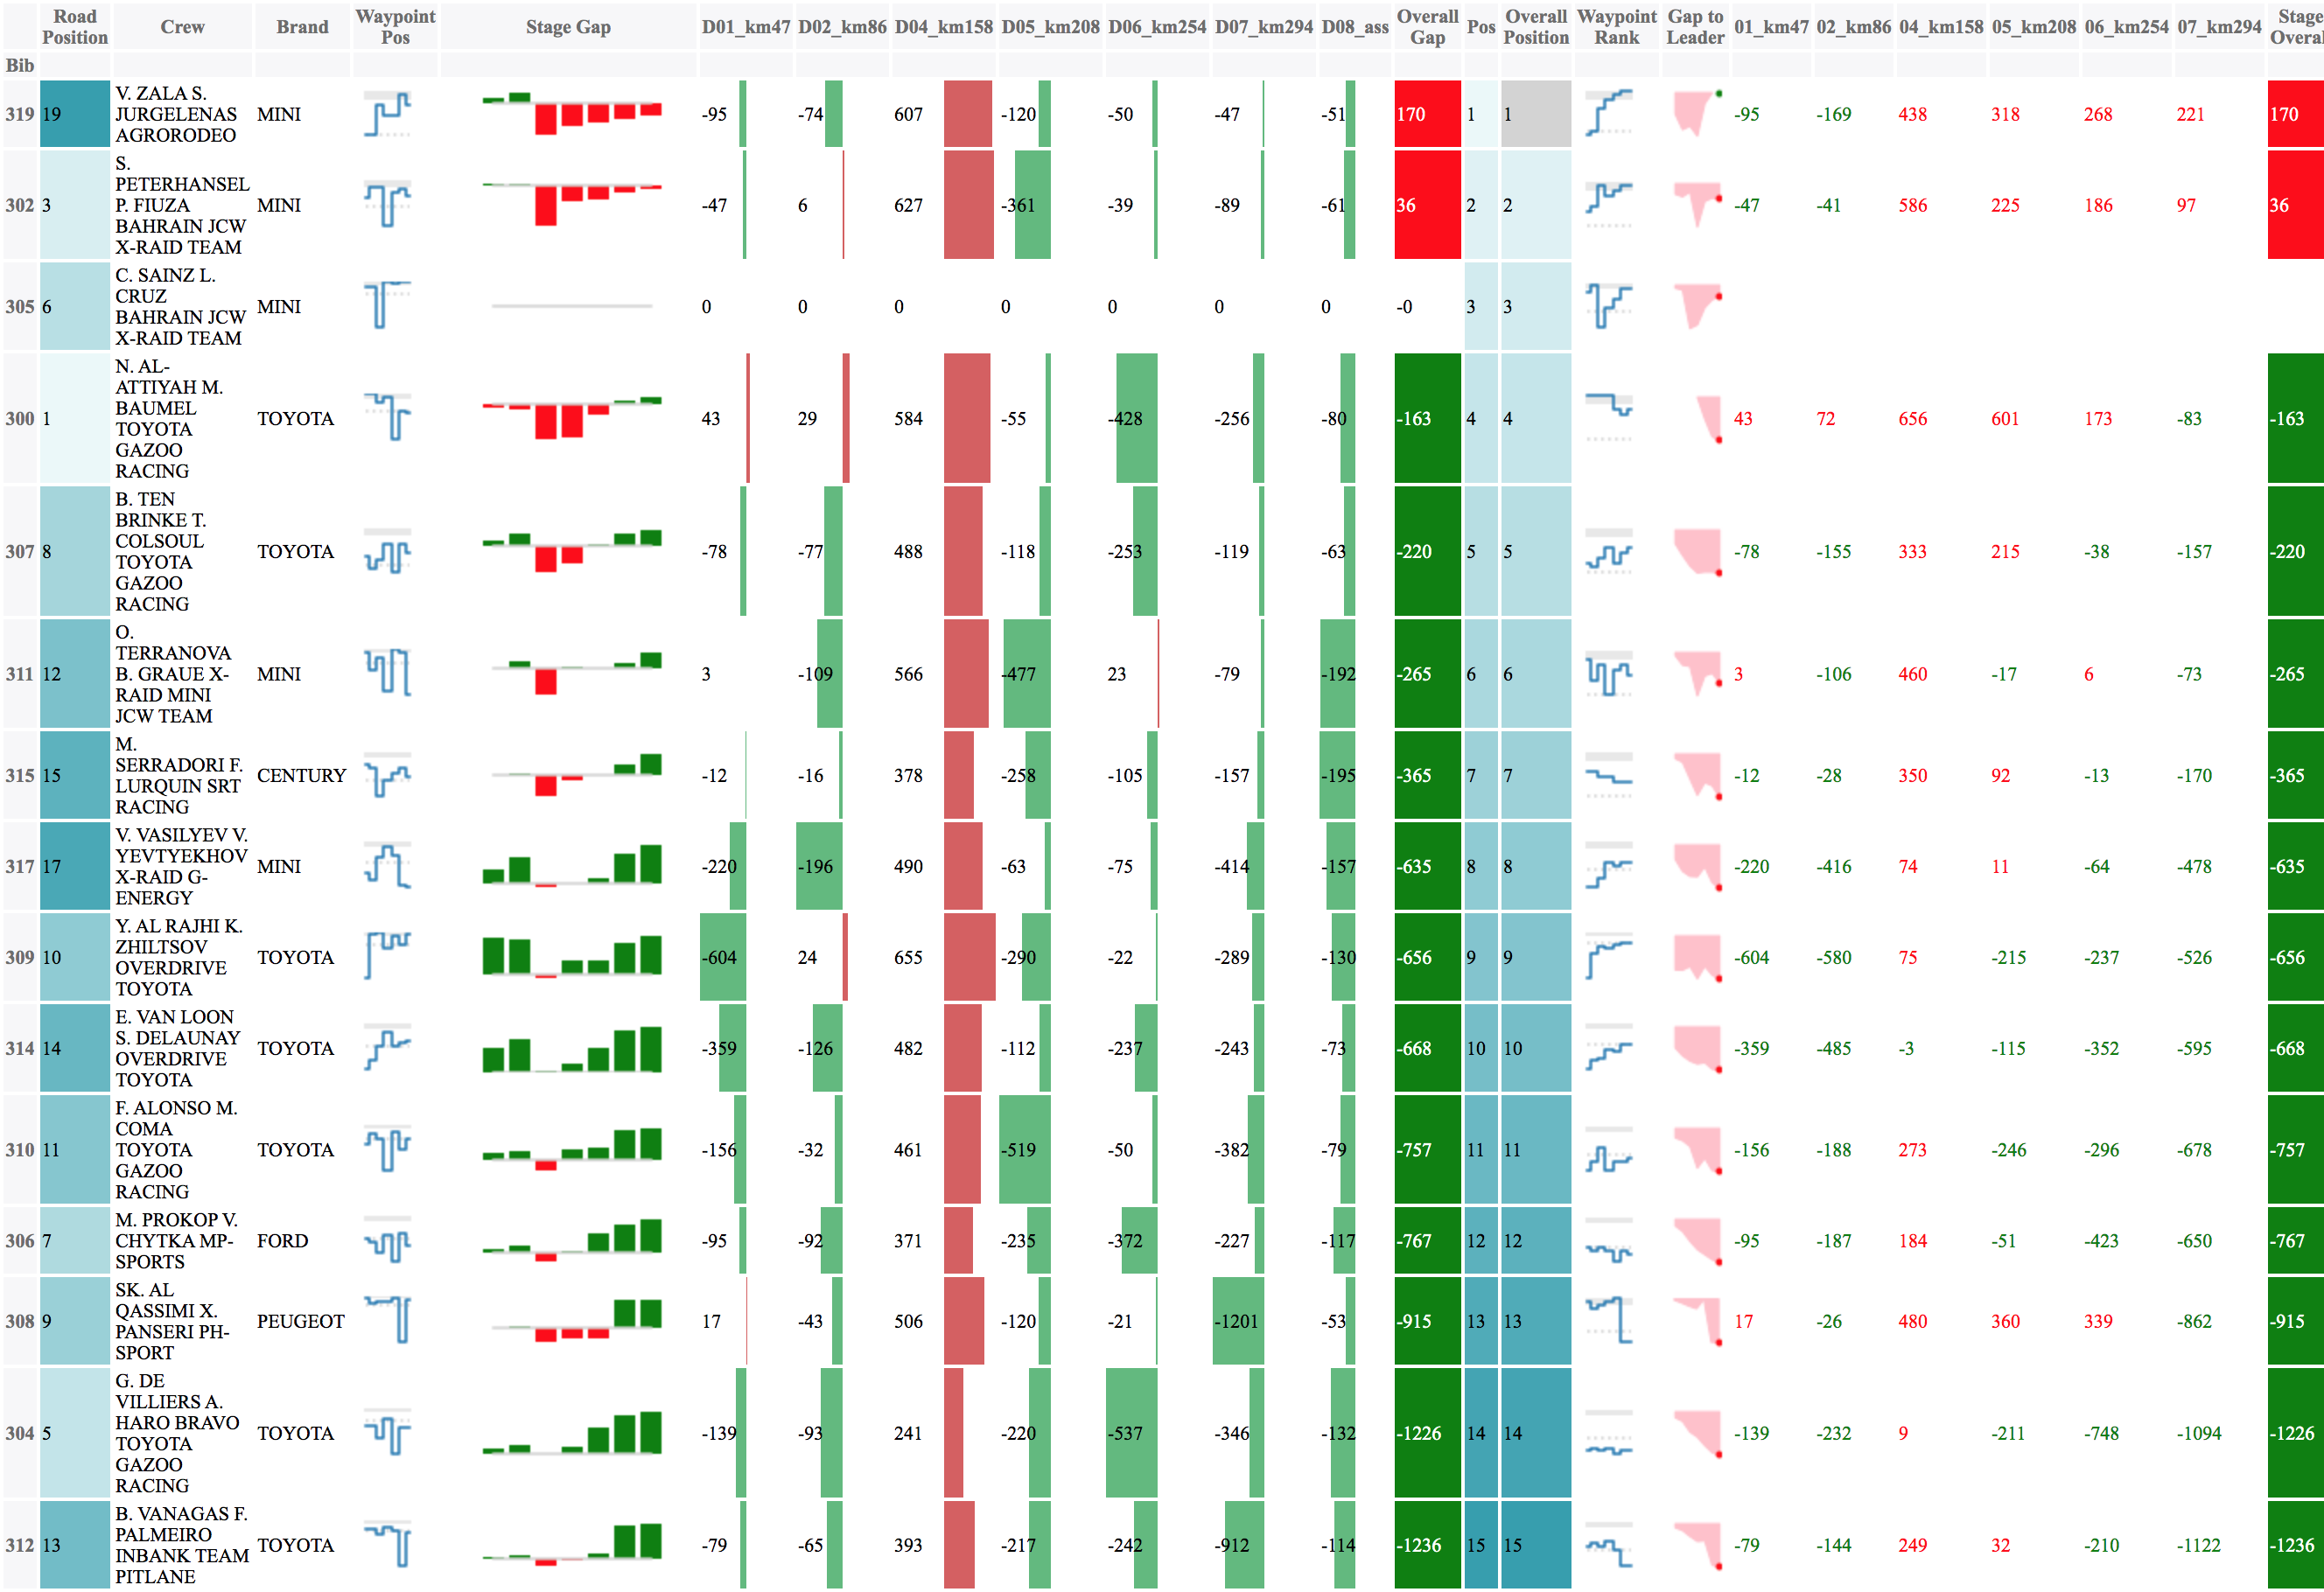

In [712]:
from IPython.display import Image
Image(img)